In [1]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np
import math 
import csv
from qmplot import manhattanplot, qqplot
from statsmodels.stats.multitest import multipletests
import warnings
warnings.filterwarnings("ignore")

# read in data

In [3]:
def combine_dataframes(directory, ext): 
    df_list = []
    
    for i in range(1, 23): 
        df = pd.read_csv(f"{directory}/cluster2_{i}.{ext}", sep="\t")
        df = df.dropna()
        df_list.append(df)
        
    return pd.concat(df_list)

In [7]:
def return_frequency(directory): 
    
    frq = combine_dataframes(directory, "gcount")
        
    frq["cluster_size"] = frq["HET_REF_ALT_CTS"] + frq["TWO_ALT_GENO_CTS"]
    frq["name"] = frq["ID"] + "_" + frq["#CHROM"].astype(str)
    frq["maf"] = (frq["TWO_ALT_GENO_CTS"] + (frq["HET_REF_ALT_CTS"]/2))/(frq["HET_REF_ALT_CTS"] + frq["TWO_ALT_GENO_CTS"] + frq["HOM_REF_CT"] )
    
    return frq

In [14]:
def return_assoc(directory): 
    
    assoc = combine_dataframes(directory, "PHENO1.glm.linear")
    assoc["name"] = assoc["ID"] + "_" + assoc["#CHROM"].astype(str)

    return assoc

### make dataframes

In [60]:
frq = return_frequency("comparison/height/adv_redone/")
assoc = return_assoc("comparison/height/adv_redone/")

# qc 

In [61]:
def perform_qc(assoc, frq, min_hom_count=3, max_frq_maf=0.05, std_thresh=3, qc_type="all"): 
    
    max_frq = frq[frq["maf"] < max_frq_maf]["name"].values
    min_hom = frq[frq["TWO_ALT_GENO_CTS"] >= min_hom_count]["name"].values

    mean, std = frq["cluster_size"].mean(), frq["cluster_size"].std()
    cluster_sharing = frq[frq["cluster_size"] <= (std_thresh*std) + mean]["name"].values
    
    all_intersection = set(cluster_sharing).intersection(set(min_hom)).intersection(set(max_frq))
    
    qc_type_dict = {"maf":max_frq, "min_hom":min_hom, "cluster_sharing":cluster_sharing,
                    "all":all_intersection}
    
    return assoc[assoc["name"].isin(qc_type_dict[qc_type])], qc_type_dict

In [62]:
def multiple_test_correction(df, test_type="bonferroni"): 
    
    df[test_type] = multipletests(df["P"], method=test_type)[0]
    df["-log P"] = -(np.log10(df["P"]))

### run QC 

In [68]:
assoc_qc, qc_dict = perform_qc(assoc, frq, qc_type="min_hom")
multiple_test_correction(assoc_qc)

In [69]:
len(qc_dict["maf"]), len(qc_dict["min_hom"]), len(qc_dict["cluster_sharing"]), len(qc_dict["all"])

(5402829, 3298, 5270322, 230)

# plots

### P value histogram 

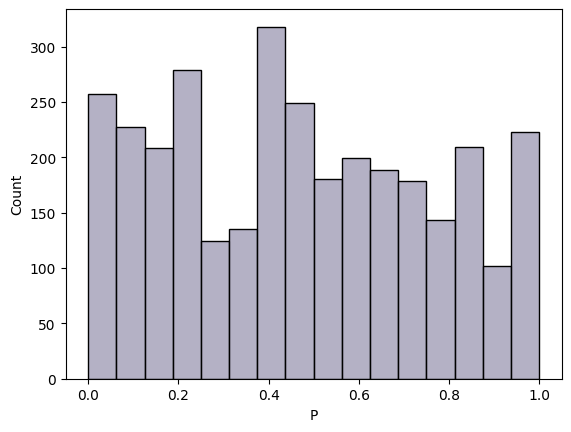

In [70]:
sns.histplot(x="P", data=assoc_qc, color="#9B97B2")
plt.show()

### QQ plot

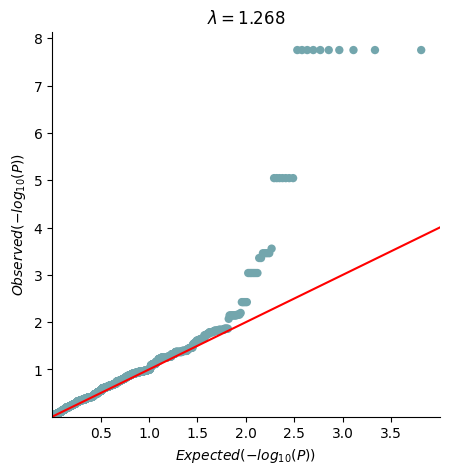

In [71]:
qqplot(data=assoc_qc["P"], color="#73A6AD", alpha=1)
sns.despine()
plt.show()

### manhattan plot

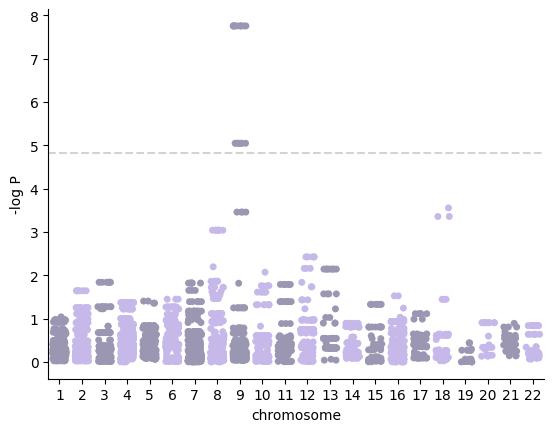

In [72]:
order = [str(i) for i in range(1, 23)]
bonf_line = -np.log10(0.05/len(assoc_qc))

sns.stripplot(x="#CHROM", y="-log P", data=assoc_qc, order=order, jitter=0.3, 
               palette=sns.color_palette(["#9B97B2", "#C7B8EA"]*11))

plt.axhline(y=bonf_line, linestyle="--", color="lightgrey") 
plt.xlabel("chromosome")
sns.despine()
plt.show()